## Forward-Design (again) 

## Imports

In [2]:
import sys; sys.path.append('../..')
import inflation, mesh, sheet_meshing
from tri_mesh_viewer import OffscreenTriMeshViewer
import numpy as np
import utils, py_newton_optimizer, benchmark
import matplotlib.pyplot as pltRun
from scipy.spatial import KDTree
from tri_mesh_viewer import TriMeshViewer as Viewer

## Load Mesh and Fused Points

In [3]:
V, E = mesh.load_raw('../data/ForwardDesign/hinge.obj')
fusedPts = list(np.loadtxt('../data/ForwardDesign/fusehingev3.txt').reshape((-1, 2)))
holePts = []

## Create Inflatable Sheet Mesh

In [8]:
m, iwv, iwbv = sheet_meshing.forward_design_mesh(V, E, fusedPts, holePts, np.prod(utils.bbox_dims(V)[0:2]) / 1e4)
isheet = inflation.InflatableSheet(m, iwv)
# --- Set material parameters ---
# --- Set material properties ---
isheet.thickness = 0.00015         # 0.15 mm (TPU nylon 70D)
isheet.youngModulus = 2.5e8        # 250 MPa


## Set Up Offscreen Viewer for Video Recording

In [9]:
oview = OffscreenTriMeshViewer(isheet, width=768, height=640, wireframe=True)

 ## Define and Find Tracked Vertices

In [10]:
target_points = np.array([
    [5.0,  0.0, 0.0],
    [5.0, 20.0, 0.0],
    [5.0, 40.0, 0.0]
])

# Get rest positions and find nearest actual vertices
V_rest = np.array([v.flatten() for v in isheet.restWallVertexPositions()])
tree = KDTree(V_rest)
tracked_indices = [tree.query(p)[1] for p in target_points]

# Store rest positions for displacement calculation
rest_positions = {idx: V_rest[idx] for idx in tracked_indices}

print("Tracked indices:", tracked_indices)
print("Tracked coordinates:", [V_rest[i] for i in tracked_indices])

Tracked indices: [184, 294, 237]
Tracked coordinates: [array([5., 0., 0.]), array([ 5., 20.,  0.]), array([ 5., 40.,  0.])]


## Set Up Tracking and Callback

In [11]:
# Dictionary to store trajectory over time
trajectory = {idx: [] for idx in tracked_indices}
framerate = 5  # Save every 5 iterations

def cb(it):
    if it % framerate == 0:
        for idx in tracked_indices:
            pos = isheet.getDeformedVtxPosition(idx, 0).flatten()
            trajectory[idx].append(pos)
        oview.update()  # Update offscreen viewer (for video)

## Run Simulation and Record Video

In [12]:
viewer = Viewer(isheet, wireframe=True)
viewer.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [13]:
benchmark.reset()
oview.recordStart('tracked_inflation3.mp4')  # Start recording

isheet.setUseTensionFieldEnergy(True)
isheet.setUseHessianProjectedEnergy(False)

opts = py_newton_optimizer.NewtonOptimizerOptions()
opts.niter = 500
isheet.pressure = 1

cr = inflation.inflation_newton(isheet, isheet.rigidMotionPinVars, opts, callback=cb)

benchmark.report()
oview.recordStop()  # End recording

InflatableSheet setVars	0.00737286	1
Newton iterations	244.342	1
    InflatableSheet energy	0.00193596	1
    InflatableSheet gradient	0.00209594	1
    Newton iterate	244.335	500
        Backtracking	4.20794	500
            InflatableSheet energy	0.6898	1005
            InflatableSheet setVars	3.46311	1005
        Compute descent direction	224.278	500
            newton_step	224.276	500
                Newton solve	210.586	506
                    CHOLMOD Numeric Factorize	204.907	505
                    Solve	5.12791	501
                        CHOLMOD Backsub	4.58641	500
                        CHOLMOD Numeric Factorize	0.117195	1
                        CHOLMOD Symbolic Factorize	0.351288	1
                hessEval	13.6291	500
                largestMagnitudeEigenvalue	0.0285709	2
        Preamble	15.6082	500
            Callback	14.4208	500
            InflatableSheet energy	0.333048	500
            InflatableSheet gradient	0.737101	500
Full time	244.411


## Export Inflated Mesh as OBJ

In [14]:
def write_obj(path, V, F):
    with open(path, "w") as f:
        for v in V:
            f.write("v {:.6f} {:.6f} {:.6f}\n".format(*v))
        for face in F:
            f.write("f {} {} {}\n".format(*(face + 1)))  # OBJ is 1-indexed

V_raw, F_raw, *_ = isheet.visualizationGeometry()
V = np.array([v.flatten() for v in V_raw], dtype=np.float64)
F = np.array([f for f in F_raw], dtype=np.int32)
write_obj("inflated_mesh3.obj", V, F)

## Plot Z Displacement + 3D Position + Optional X/Y Displacements

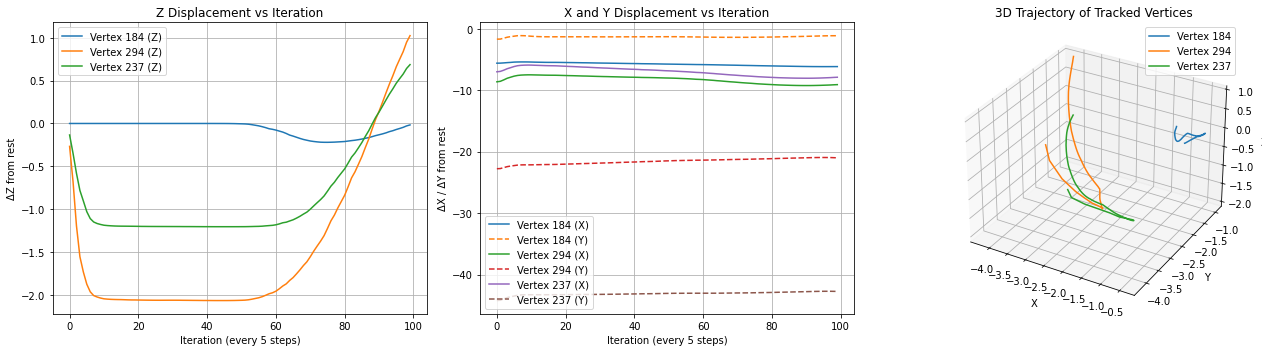

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(18, 5))

# --- Z Displacement ---
ax1 = fig.add_subplot(1, 3, 1)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        z_disp = traj[:, 2] - rest_positions[idx][2]
        ax1.plot(range(len(traj)), z_disp, label=f"Vertex {idx} (Z)")
ax1.set_title("Z Displacement vs Iteration")
ax1.set_xlabel(f"Iteration (every {framerate} steps)")
ax1.set_ylabel("ΔZ from rest")
ax1.grid(True)
ax1.legend()

# --- X and Y Displacement ---
ax2 = fig.add_subplot(1, 3, 2)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        x_disp = traj[:, 0] - rest_positions[idx][0]
        y_disp = traj[:, 1] - rest_positions[idx][1]
        ax2.plot(range(len(traj)), x_disp, label=f"Vertex {idx} (X)")
        ax2.plot(range(len(traj)), y_disp, linestyle='--', label=f"Vertex {idx} (Y)")
ax2.set_title("X and Y Displacement vs Iteration")
ax2.set_xlabel(f"Iteration (every {framerate} steps)")
ax2.set_ylabel("ΔX / ΔY from rest")
ax2.grid(True)
ax2.legend()

# --- 3D Trajectory ---
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        ax3.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")
ax3.set_title("3D Trajectory of Tracked Vertices")
ax3.set_xlabel("X")
ax3.set_ylabel("Y")
ax3.set_zlabel("Z")
ax3.legend()

plt.tight_layout()
plt.show()


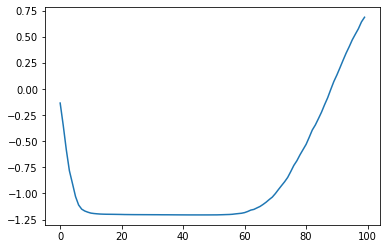

In [16]:
plt.plot(range(len(traj)), traj[:, 2], label=f"Vertex {idx} (Z)")


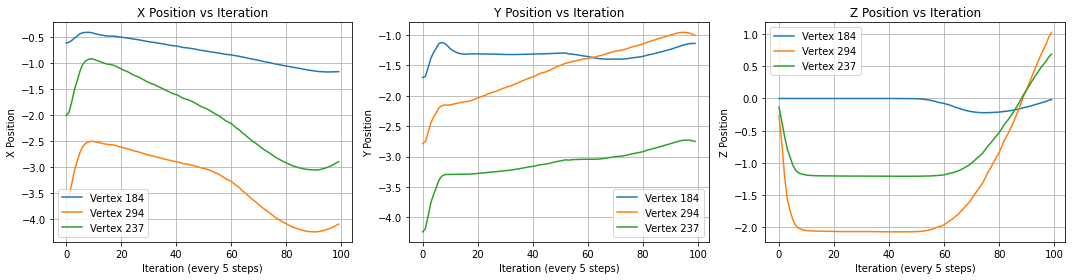

In [17]:
# Plot absolute positions (X, Y, Z) vs iteration for each tracked vertex
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] <= 1:
        continue
    iterations = range(len(traj))
    axs[0].plot(iterations, traj[:, 0], label=f"Vertex {idx}")
    axs[1].plot(iterations, traj[:, 1], label=f"Vertex {idx}")
    axs[2].plot(iterations, traj[:, 2], label=f"Vertex {idx}")

# X
axs[0].set_title("X Position vs Iteration")
axs[0].set_xlabel(f"Iteration (every {framerate} steps)")
axs[0].set_ylabel("X Position")
axs[0].grid(True)
axs[0].legend()

# Y
axs[1].set_title("Y Position vs Iteration")
axs[1].set_xlabel(f"Iteration (every {framerate} steps)")
axs[1].set_ylabel("Y Position")
axs[1].grid(True)
axs[1].legend()

# Z
axs[2].set_title("Z Position vs Iteration")
axs[2].set_xlabel(f"Iteration (every {framerate} steps)")
axs[2].set_ylabel("Z Position")
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()

In [18]:
for idx in tracked_indices:
    print(f"Vertex {idx}: rest = {V_rest[idx]}, first position = {trajectory[idx][0]}")


Vertex 184: rest = [5. 0. 0.], first position = [-6.06502212e-01 -1.69729133e+00 -5.68864842e-14]
Vertex 294: rest = [ 5. 20.  0.], first position = [-3.6360541  -2.78497276 -0.26742427]
Vertex 237: rest = [ 5. 40.  0.], first position = [-2.00555063 -4.23863845 -0.13443068]


## Plot Z Displacement Over Time

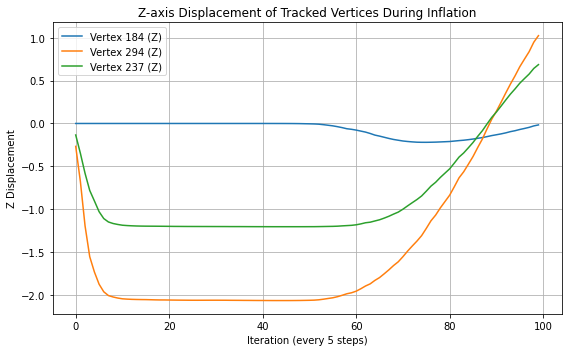

In [19]:
plt.figure(figsize=(8, 5))
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 2], label=f"Vertex {idx} (Z)")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("Z Displacement")
plt.title("Z-axis Displacement of Tracked Vertices During Inflation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot 3D Trajectories

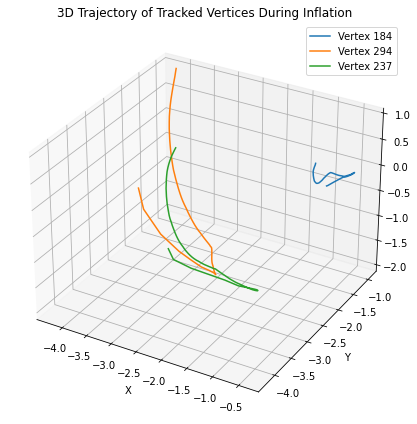

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], label=f"Vertex {idx}")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("3D Trajectory of Tracked Vertices During Inflation")
ax.legend()
plt.tight_layout()
plt.show()

 ## Plot X and Y Displacement

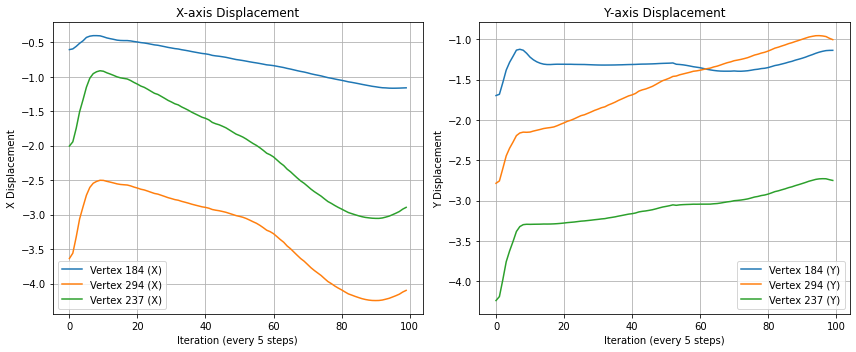

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 0], label=f"Vertex {idx} (X)")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("X Displacement")
plt.title("X-axis Displacement")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
for idx in tracked_indices:
    traj = np.array(trajectory[idx])
    if traj.shape[0] > 1:
        plt.plot(range(len(traj)), traj[:, 1], label=f"Vertex {idx} (Y)")
plt.xlabel(f"Iteration (every {framerate} steps)")
plt.ylabel("Y Displacement")
plt.title("Y-axis Displacement")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

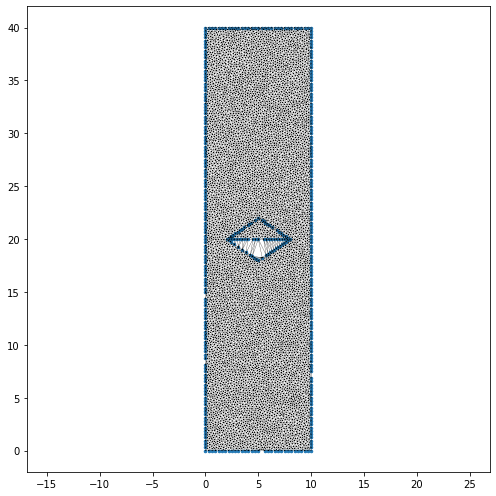

In [22]:
import visualization
visualization.plot_2d_mesh(m, pointList=np.where(iwv))

In [23]:
viewer = Viewer(isheet, wireframe=True)
viewer.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…